# Laboratorio de arreglos adaptativos


*   Manuel Mollon, Legajo: 58023
*   Ezequiel Vijande, Legajo: 58057



## Librerias

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt

## 1. Modelar la respuesta de un arreglo de M sensores espaciados por la distancia d a una señal de banda base compleja x(n) modulada a una frecuencia de longitud de onda $\lambda_c$ y proveniente desde la dirección $φ_s$. Asumir que x(n) se presenta en el primer sensor del arreglo sin retardo. La función debe cumplir con el prototipo: $$def \quad model\_signal(M, d, x, lambda\_c, phi\_s)$$

In [2]:

def model_signal(M,d,x,lambda_c,phi_s):
  try:
    size_x = len(x)
  except:
    size_x = 1
  response = np.zeros( shape=(size_x,M), dtype=complex )
  #Modelo el vector con el delay correspondiente a cada sensor
  phase = -1j*( 2*math.pi*d*np.sin(phi_s)*np.linspace(start=0,stop=M-1,num=M,dtype=int) )/lambda_c
  v = np.exp( phase )
  if ( np.isscalar(x) ):
    response = x*v
  else:
    for i in range(0,size_x):
      response[i] = x[i] * v
  return response


In [3]:
lambda_c = 5
x=1
phi_s=0.25*math.pi
M=6
d=7
result = model_signal(M,d,x,lambda_c,phi_s)
print(result)

[1.        +0.j         0.99800675+0.06310723j 0.99203495+0.12596288j
 0.98210841+0.18831639j 0.9682667 +0.24991917j 0.950565  +0.31052565j]


## 2. Modelar el ruido térmico de energía $\sigma^2$ de un arreglo de M sensores para N instantes temporales. La función debe cumplir con el prototipo: $$def \quad model\_noise(M, N, sigma\_2)$$

In [4]:
def model_noise(M,N,sigma_2):
  return np.random.normal(scale=np.sqrt(sigma_2), size=(N,M) )

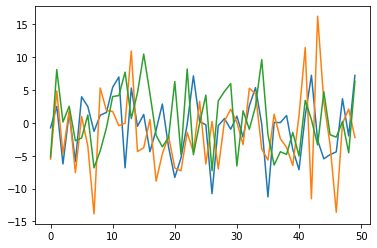

In [5]:
N=50
M=3
sigma_2 = 20
plt.plot( model_noise(M,N,sigma_2) )
plt.show()

## 3. Aprovechando las funciones del punto 1 y 2, estimar el espectro de potencia espacial de una señal de banda base compleja compuesta por una señal $x_1(n)$ de ruido blanco gaussiano de media cero proveniente desde $φ_{s_1} = -45°$ y energía $σ^2_{x_1} = 1$, y una señal $x_2(n)$ de ruido blanco gaussiano de media cero proveniente desde $φ_{s_2} = -65°$ y energía $σ^2_{x_2} = 0.1$. La señal es electromagnética, se transmite por aire y es modulada a $F_c = 3GHz$; el ruido de los sensores es $σ^2_n = 0.005$. Para un taper con ventana rectangular y un taper con ventana de Hamming:

### a) Determinar la cantidad de sensores M y el espaciamiento d óptimo.

Del Criterio de Nyquist espacial se tiene que para no sufrir de aliasing se debe cumplir con:
$$ d\leq \frac{\lambda}{2} $$
Si la señal puede aproximarse como de banda angosta ($BW<<F_c$) entonces se puede tomar:
 $$\lambda=\lambda_c=\frac{c}{F_c}=0.1m$$ 
 Donde $c$ es la velocidad de la luz y $F_c$ la frecuencia temporal de la portadora.

Por lo que se tiene que la separacion maxima posible sin sufrir aliasing sera de:
$$d_{max}=\frac{\lambda_c}{2}=0.05m$$ 

Tambien existe una relacion entre la separacion d de los sensores y la resolucion en frecuencia. Definiendo la apertura como:
$$L=M\cdot d$$ 
Se tiene que el ancho del lobulo principal del patron de directividad es:
$$\triangle \phi_{3dB}\approx \frac{\lambda}{L}$$

In [6]:
#Parametros
N = 2048
M= 10
sigma_x1 = 1
sigma_x2 = np.sqrt(0.1)
sigma_n = np.sqrt(0.005)
phi_x1 = -45 *(math.pi/180) #Angulo de arribo de x1 en radianes
phi_x2 = -65 *(math.pi/180) #Angulo de arribo de x2 en radianes
Fc = 3e9                    #Frecuencia de portadora de 3GHZ
lambda_c = 3e8/Fc
d = lambda_c /2

#Modelado de las señales
x1 = np.random.normal(scale = sigma_x1, size=N )
x2 = np.random.normal(scale = sigma_x2, size=N )
n1= model_noise(M,N,sigma_n)
n2= model_noise(M,N,sigma_n)
#Señal recibida
r1 = model_signal(M,d,x1,lambda_c,phi_x1) + n1
r2 = model_signal(M,d,x2,lambda_c,phi_x2) + n2
recieved = r1+r2

### b) Determinar la cantidad de instantes temporales N óptima.

### c) Determinar la cantidad de puntos óptima para el barrido de φ.

### d) Representar el espectro de potencia espacial en función de φ.